In [5]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import numpy as np
import pandas as pd
import math
import json
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
import joblib as jb
import scipy.sparse
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import svds
import warnings; warnings.simplefilter('ignore')
%matplotlib inline

## Loading the dataset and add headers

In [6]:
columns=['userId', 'productId', 'ratings','timestamp']
groceries_df=pd.read_csv('ratings_Grocery_and_Gourmet_Food.csv',names=columns)

In [7]:
groceries_df

,userId,productId,ratings,timestamp
0,A1ZQZ8RJS1XVTX,0657745316,5.0,1381449600
1,A31W38VGZAUUM4,0700026444,5.0,1354752000
2,A3I0AV0UJX5OH0,1403796890,1.0,1385942400
3,A3QAAOLIXKV383,1403796890,3.0,1307836800
4,AB1A5EGHHVA9M,141278509X,5.0,1332547200
...,...,...,...,...
1297151,A1DGBQQIBHTLPF,B00LOZ7F0S,5.0,1405555200
1297152,A3DYJ90MXMH04P,B00LOZ7F0S,5.0,1404950400
1297153,AWQYAJV2QWLWA,B00LOZ7F0S,5.0,1405209600
1297154,A2AT0AI6QKSY2C,B00LOZ7F0S,5.0,1405382400


In [8]:
groceries_df.drop('timestamp',axis=1,inplace=True)

In [9]:
groceries_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1297156 entries, 0 to 1297155
Data columns (total 3 columns):
 #   Column     Non-Null Count    Dtype  
---  ------     --------------    -----  
 0   userId     1297156 non-null  object 
 1   productId  1297156 non-null  object 
 2   ratings    1297156 non-null  float64
dtypes: float64(1), object(2)
memory usage: 29.7+ MB


In [10]:
rows,columns=groceries_df.shape
print('Number of rows: ',rows)
print('Number of columns: ',columns)

Number of rows:  1297156
Number of columns:  3


In [11]:
groceries_df.dtypes

userId        object
productId     object
ratings      float64
dtype: object

In [13]:
groceries_df1=groceries_df.iloc[:50000,0:]

In [15]:
## Since the data is very big. Consider groceries_df1 named dataframe with first 50000 rows and all columns from 0 of dataset.

In [16]:
groceries_df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   userId     50000 non-null  object 
 1   productId  50000 non-null  object 
 2   ratings    50000 non-null  float64
dtypes: float64(1), object(2)
memory usage: 1.1+ MB


In [17]:
groceries_df1['ratings'].describe().transpose()

count    50000.000000
mean         4.281860
std          1.259685
min          1.000000
25%          4.000000
50%          5.000000
75%          5.000000
max          5.000000
Name: ratings, dtype: float64

In [18]:
#Finding the minimum and maximum ratings
print('Minimum rating is: %d' %(groceries_df1.ratings.min()))
print('Maximum rating is: %d' %(groceries_df1.ratings.max()))

Minimum rating is: 1
Maximum rating is: 5


In [19]:
## Rating are on the scale 1 to 5.

In [20]:
## now we handle the data as in check for the missing values as not all the consumers rate a certain product

In [21]:
print('Number of missing values across columns: \n',groceries_df1.isnull().sum())

Number of missing values across columns: 
 userId       0
productId    0
ratings      0
dtype: int64


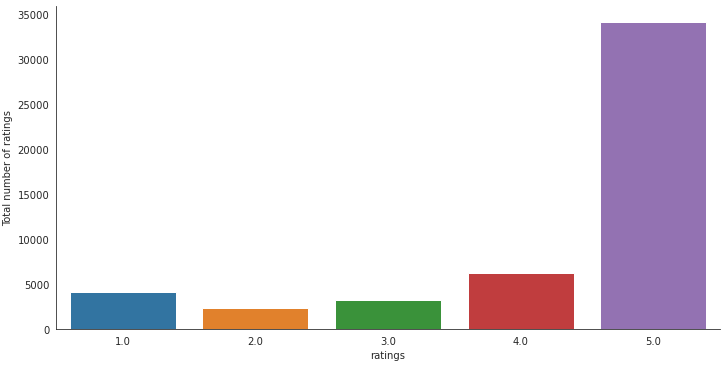

In [22]:
# now lets check the ratings of the products
with sns.axes_style('white'):
    g = sns.factorplot("ratings", data=groceries_df1, aspect=2.0,kind='count')
    g.set_ylabels("Total number of ratings")

In [24]:
# Number of unique user id  in the data
print('Number of unique users in Raw data = ', groceries_df1['userId'].nunique())
# Number of unique product id  in the data
print('Number of unique product in Raw data = ', groceries_df1['productId'].nunique())

Number of unique users in Raw data =  45412
Number of unique product in Raw data =  6387


In [25]:
##  Taking the subset of dataset 
#Check the top 10 users based on ratings
most_rated=groceries_df1.groupby('userId').size().sort_values(ascending=False)[:10]
print('Top 10 users based on ratings: \n',most_rated)

Top 10 users based on ratings: 
 userId
A281NPSIMI1C2R    71
A3D6OI36USYOU1    52
A24TCT2CY6KY68    52
A1YUL9PCJR3JTY    43
A2NYK9KWFMJV4Y    39
A6GMEO3VRY51S     34
A2R6RA8FRBS608    29
A3D6TFYRMIV3ZL    27
A26HFSVLAGULIM    22
A26A64X86VL1R4    20
dtype: int64


In [31]:
counts=groceries_df1.userId.value_counts()
groceries_df1_final=groceries_df1[groceries_df1.userId.isin(counts[counts>=15].index)]
print('Number of users who have rated 25 or more items =', len(groceries_df1_final))
print('Number of unique users in the final data = ', groceries_df1_final['userId'].nunique())
print('Number of unique products in the final data = ', groceries_df1_final['userId'].nunique())

Number of users who have rated 25 or more items = 502
Number of unique users in the final data =  17
Number of unique products in the final data =  17


In [32]:
#constructing the pivot table
final_ratings_matrix = groceries_df1_final.pivot(index = 'userId', columns ='productId', values = 'ratings').fillna(0)
final_ratings_matrix.head()

productId,B000052Y74,B0000537AF,B0000691JF,B0000691JG,B0000C69FB,B0000C69FI,B0000CCZYY,B0000CD03D,B0000CDBQZ,B0000CEO7M,...,B0005Z7IAA,B0005Z7N2S,B0005Z7PI0,B0005ZGQJO,B0005ZGXVK,B0005ZHBLG,B0005ZHDDM,B0005ZHE1I,B0005ZHOUO,B0005ZHPFI
userId,,,,,,,,,,,,,,,,,,,,,
A1IU7S4HCK1XK0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A1LACH6MLQWZ,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A1TJT6GXDGNN8Q,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A1YUL9PCJR3JTY,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A24TCT2CY6KY68,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [33]:
print('Shape of final_ratings_matrix: ', final_ratings_matrix.shape)

Shape of final_ratings_matrix:  (17, 458)


In [34]:
#splitting the data

In [35]:
train_data, test_data = train_test_split(groceries_df1_final, test_size = 0.3, random_state=0)
train_data.head()

,userId,productId,ratings
44353,A26HFSVLAGULIM,B00032EWD6,5.0
9233,A2B7BUH8834Y6M,B0000E2Y69,5.0
12587,A281NPSIMI1C2R,B0000U7R6A,5.0
8788,A2F2S1L61X1LA9,B0000DK37G,4.0
4123,A6GMEO3VRY51S,B0000D15YU,5.0


In [36]:
print('Shape of training data: ',train_data.shape)
print('Shape of testing data: ',test_data.shape)

Shape of training data:  (351, 3)
Shape of testing data:  (151, 3)


In [37]:
## Building Popularity Recommender model

In [38]:
train_data_grouped = train_data.groupby('productId').agg({'userId': 'count'}).reset_index()
train_data_grouped.rename(columns = {'userId': 'score'},inplace=True)
train_data_grouped.head(40)

,productId,score
0,B000052Y74,1
1,B0000691JF,1
2,B0000691JG,1
3,B0000CEO7M,1
4,B0000CFLCQ,1
5,B0000CH4FT,1
6,B0000CNU08,1
7,B0000CNU1X,1
8,B0000CNU2Q,1
9,B0000CNU4K,1


In [39]:
#Sorting the products on recommendation score 
train_data_sort = train_data_grouped.sort_values(['score', 'productId'], ascending = [0,1]) 
      
#Generate a recommendation rank based upon score 
train_data_sort['rank'] = train_data_sort['score'].rank(ascending=0, method='first') 
          
#Get the top 5 recommendations 
popularity_recommendations = train_data_sort.head(5) 
popularity_recommendations

,productId,score,rank
24,B0000DBN1L,3,1.0
20,B0000DBN1F,2,2.0
21,B0000DBN1G,2,3.0
25,B0000DBN1M,2,4.0
26,B0000DBN1O,2,5.0


In [40]:
# Use popularity based recommender model to make predictions
def recommend(user_id):     
    user_recommendations = popularity_recommendations 
          
    #Adding user_id column  
    user_recommendations['userId'] = user_id 
      
    # user_id column to the front 
    cols = user_recommendations.columns.tolist() 
    cols = cols[-1:] + cols[:-1] 
    user_recommendations = user_recommendations[cols] 
          
    return user_recommendations

In [41]:
find_recom = [10,100,150]   # This list is user choice.
for i in find_recom:
    print("The list of recommendations for the userId: %d\n" %(i))
    print(recommend(i))    
    print("\n")

The list of recommendations for the userId: 10

    userId   productId  score  rank
24      10  B0000DBN1L      3   1.0
20      10  B0000DBN1F      2   2.0
21      10  B0000DBN1G      2   3.0
25      10  B0000DBN1M      2   4.0
26      10  B0000DBN1O      2   5.0


The list of recommendations for the userId: 100

    userId   productId  score  rank
24     100  B0000DBN1L      3   1.0
20     100  B0000DBN1F      2   2.0
21     100  B0000DBN1G      2   3.0
25     100  B0000DBN1M      2   4.0
26     100  B0000DBN1O      2   5.0


The list of recommendations for the userId: 150

    userId   productId  score  rank
24     150  B0000DBN1L      3   1.0
20     150  B0000DBN1F      2   2.0
21     150  B0000DBN1G      2   3.0
25     150  B0000DBN1M      2   4.0
26     150  B0000DBN1O      2   5.0




In [42]:
#THE ABOVE MODEL DOESNT RECOMMEND PRODUCTS ON PERSONALIZATION BUT IT SHOWS THE MOST POPULAR

In [45]:
#Building Collaborative Filtering recommender model.

In [46]:
groceries_df_CF = pd.concat([train_data, test_data]).reset_index()
groceries_df_CF.head()

,index,userId,productId,ratings
0,44353,A26HFSVLAGULIM,B00032EWD6,5.0
1,9233,A2B7BUH8834Y6M,B0000E2Y69,5.0
2,12587,A281NPSIMI1C2R,B0000U7R6A,5.0
3,8788,A2F2S1L61X1LA9,B0000DK37G,4.0
4,4123,A6GMEO3VRY51S,B0000D15YU,5.0


In [47]:
#User Based Collaborative Filtering model

In [48]:
pivot_df = groceries_df_CF.pivot(index = 'userId', columns ='productId', values = 'ratings').fillna(0)
pivot_df.head()

productId,B000052Y74,B0000537AF,B0000691JF,B0000691JG,B0000C69FB,B0000C69FI,B0000CCZYY,B0000CD03D,B0000CDBQZ,B0000CEO7M,...,B0005Z7IAA,B0005Z7N2S,B0005Z7PI0,B0005ZGQJO,B0005ZGXVK,B0005ZHBLG,B0005ZHDDM,B0005ZHE1I,B0005ZHOUO,B0005ZHPFI
userId,,,,,,,,,,,,,,,,,,,,,
A1IU7S4HCK1XK0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A1LACH6MLQWZ,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A1TJT6GXDGNN8Q,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A1YUL9PCJR3JTY,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A24TCT2CY6KY68,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [49]:
print('Shape of the pivot table: ', pivot_df.shape)

Shape of the pivot table:  (17, 458)


In [50]:
#defining user index from 0 to 10
pivot_df['user_index'] = np.arange(0, pivot_df.shape[0], 1)
pivot_df.head()

productId,B000052Y74,B0000537AF,B0000691JF,B0000691JG,B0000C69FB,B0000C69FI,B0000CCZYY,B0000CD03D,B0000CDBQZ,B0000CEO7M,...,B0005Z7N2S,B0005Z7PI0,B0005ZGQJO,B0005ZGXVK,B0005ZHBLG,B0005ZHDDM,B0005ZHE1I,B0005ZHOUO,B0005ZHPFI,user_index
userId,,,,,,,,,,,,,,,,,,,,,
A1IU7S4HCK1XK0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
A1LACH6MLQWZ,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
A1TJT6GXDGNN8Q,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
A1YUL9PCJR3JTY,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
A24TCT2CY6KY68,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4


In [51]:
##As this is a sparse matrix we will use SVD.

In [52]:
U, sigma, Vt = svds(pivot_df, k = 10)

In [53]:
print('Left singular matrix: \n',U)

Left singular matrix: 
 [[-2.76307590e-01 -1.46976197e-01  1.06876083e-02  9.68538300e-04
  -1.60584418e-03 -2.31775326e-03 -3.92299962e-02  7.18514345e-03
   1.15388195e-03 -3.71180115e-03]
 [ 7.49226569e-02 -3.92983925e-02  4.34279488e-03  2.12468077e-04
  -1.44003878e-03 -1.35663345e-03 -3.90654853e-02  1.10967685e-02
   1.13434870e-02 -2.53556575e-02]
 [ 1.86234478e-03 -3.69959627e-03 -3.73733621e-05 -9.19416099e-04
   2.46767999e-03  7.45394664e-03 -2.28300779e-03 -4.69799007e-02
  -3.80135163e-02 -5.33767271e-02]
 [ 4.74732182e-03  5.30758080e-02  2.78667728e-02 -1.41966430e-02
   1.46083472e-01 -3.63172703e-02 -9.23694318e-01  8.88186194e-02
   1.36951421e-01 -1.35300180e-01]
 [-1.31694367e-02  4.04336386e-02  1.20046125e-02 -9.84251316e-01
  -2.18635634e-02 -1.19400400e-02  3.48894015e-02  1.29519285e-01
  -4.59187423e-02 -8.85380421e-02]
 [-4.83877994e-03 -9.41982135e-02  1.66654804e-02  5.23305613e-04
   7.20318156e-03 -1.18910138e-02 -2.52458800e-01  6.35594235e-02
   2.9188

In [54]:

print('Sigma: \n',sigma)

Sigma: 
 [20.57823769 21.37422084 24.53859617 26.29703017 26.8482922  28.57779503
 29.4936247  32.673567   40.96216882 49.15389005]


In [55]:
# As sigma is not a diagonal matrix we have to convert it into diagonal matrix.

In [56]:
# Constructing diagonal array in SVD
sigma = np.diag(sigma)
print('Diagonal matrix: \n',sigma)

Diagonal matrix: 
 [[20.57823769  0.          0.          0.          0.          0.
   0.          0.          0.          0.        ]
 [ 0.         21.37422084  0.          0.          0.          0.
   0.          0.          0.          0.        ]
 [ 0.          0.         24.53859617  0.          0.          0.
   0.          0.          0.          0.        ]
 [ 0.          0.          0.         26.29703017  0.          0.
   0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.         26.8482922   0.
   0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.         28.57779503
   0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
  29.4936247   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.         32.673567    0.          0.        ]
 [ 0.          0.          0.        

In [57]:
print('Right singular matrix: \n',Vt)

Right singular matrix: 
 [[ 0.00167766  0.14025767  0.00209707 ...  0.00167766 -0.00472405
   0.05772959]
 [ 0.05832415 -0.12386318  0.07290519 ...  0.05832415  0.01293773
  -0.15438715]
 [ 0.12433113 -0.00389801  0.15541391 ...  0.12433113  0.00201579
  -0.01901671]
 ...
 [ 0.02572942  0.01601402  0.03216178 ...  0.02572942 -0.08365877
   0.26445625]
 [-0.01030711 -0.00782514 -0.01288389 ... -0.01030711 -0.04366928
  -0.24862413]
 [-0.01777926 -0.01447308 -0.02222407 ... -0.01777926 -0.045761
  -0.72694847]]


In [58]:
#Predicted ratings
all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt) 
# Convert predicted ratings to dataframe
preds_df = pd.DataFrame(all_user_predicted_ratings, columns = pivot_df.columns)
preds_df.head()

productId,B000052Y74,B0000537AF,B0000691JF,B0000691JG,B0000C69FB,B0000C69FI,B0000CCZYY,B0000CD03D,B0000CDBQZ,B0000CEO7M,...,B0005Z7N2S,B0005Z7PI0,B0005ZGQJO,B0005ZGXVK,B0005ZHBLG,B0005ZHDDM,B0005ZHE1I,B0005ZHOUO,B0005ZHPFI,user_index
0,-0.149695,-0.403178,-0.187119,-0.187119,-0.024192,0.114224,-0.065771,1.407190,-0.025348,-0.024192,...,-0.017503,1.905574,-0.017503,-0.024192,0.281438,-0.010139,-0.014515,-0.149695,-0.025348,0.333092
1,-0.005445,0.340070,-0.006806,-0.006806,0.062134,0.161124,0.048007,-0.153299,-0.007306,0.062134,...,-0.008514,-0.219070,-0.008514,0.062134,-0.030660,-0.002923,0.037280,-0.005445,-0.007306,1.099760
2,0.012957,0.038887,0.016196,0.016196,-0.002349,-0.000535,0.003805,0.019337,0.338929,-0.002349,...,0.201247,0.018902,0.201247,-0.002349,0.003867,0.135572,-0.001410,0.012957,0.338929,1.887312
3,-0.014943,-0.132666,-0.018678,-0.018678,-0.033460,3.698555,0.201405,-0.162943,-0.011183,-0.033460,...,-0.006848,-0.020163,-0.006848,-0.033460,-0.032589,-0.004473,-0.020076,-0.014943,-0.011183,3.150607
4,-0.012268,-0.075385,-0.015334,-0.015334,-0.001078,-0.005608,-0.004433,-0.026111,-0.006559,-0.001078,...,-0.004304,-0.042254,-0.004304,-0.001078,-0.005222,-0.002623,-0.000647,-0.012268,-0.006559,4.079006


In [59]:
# Recommend the items with the highest predicted ratings

def recommend_items(userID, pivot_df, preds_df, num_recommendations):
    # index starts at 0  
    user_idx = userID-1 
    # Get and sort the user's ratings
    sorted_user_ratings = pivot_df.iloc[user_idx].sort_values(ascending=False)
    #sorted_user_ratings
    sorted_user_predictions = preds_df.iloc[user_idx].sort_values(ascending=False)
    #sorted_user_predictions
    temp = pd.concat([sorted_user_ratings, sorted_user_predictions], axis=1)
    temp.index.name = 'Recommended Items'
    temp.columns = ['user_ratings', 'user_predictions']
    temp = temp.loc[temp.user_ratings == 0]   
    temp = temp.sort_values('user_predictions', ascending=False)
    print('\nBelow are the recommended items for user(user_id = {}):\n'.format(userID))
    print(temp.head(num_recommendations))

In [60]:
userID = 4
num_recommendations = 5
recommend_items(userID, pivot_df, preds_df, num_recommendations)


Below are the recommended items for user(user_id = 4):

                   user_ratings  user_predictions
Recommended Items                                
B0001VVCYG                  0.0          1.276359
B00028PPO6                  0.0          1.276359
B00028Q9NC                  0.0          1.021087
B00014CZP8                  0.0          1.021087
B00028Q9NW                  0.0          1.021087


In [61]:
userID = 6
num_recommendations = 5
recommend_items(userID, pivot_df, preds_df, num_recommendations)


Below are the recommended items for user(user_id = 6):

                   user_ratings  user_predictions
Recommended Items                                
B0000WA990                  0.0          1.387020
B00028LU18                  0.0          1.362479
B0001GSPBO                  0.0          1.276359
B0001M0ZZW                  0.0          1.276359
B0001GSPAU                  0.0          1.276359


In [62]:
userID = 8
num_recommendations = 5
recommend_items(userID, pivot_df, preds_df, num_recommendations)


Below are the recommended items for user(user_id = 8):

                   user_ratings  user_predictions
Recommended Items                                
B00028PPO6                  0.0          0.110661
B0001VVCYG                  0.0          0.110661
B00028Q9NC                  0.0          0.088529
B00014EAVK                  0.0          0.088529
B00014CZP8                  0.0          0.088529


In [63]:
##Since, it is a Collaborative recommender model, so, all the three users are given different recommendations based on users past behaviour.

In [64]:
##Evaluation of Collabrative recommendation model

In [65]:
final_ratings_matrix.head()

productId,B000052Y74,B0000537AF,B0000691JF,B0000691JG,B0000C69FB,B0000C69FI,B0000CCZYY,B0000CD03D,B0000CDBQZ,B0000CEO7M,...,B0005Z7IAA,B0005Z7N2S,B0005Z7PI0,B0005ZGQJO,B0005ZGXVK,B0005ZHBLG,B0005ZHDDM,B0005ZHE1I,B0005ZHOUO,B0005ZHPFI
userId,,,,,,,,,,,,,,,,,,,,,
A1IU7S4HCK1XK0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A1LACH6MLQWZ,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A1TJT6GXDGNN8Q,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A1YUL9PCJR3JTY,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A24TCT2CY6KY68,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [66]:
# Average ACTUAL rating for each item
final_ratings_matrix.mean().head()

productId
B000052Y74    0.235294
B0000537AF    0.294118
B0000691JF    0.294118
B0000691JG    0.294118
B0000C69FB    0.294118
dtype: float64

In [67]:
preds_df.head()

productId,B000052Y74,B0000537AF,B0000691JF,B0000691JG,B0000C69FB,B0000C69FI,B0000CCZYY,B0000CD03D,B0000CDBQZ,B0000CEO7M,...,B0005Z7N2S,B0005Z7PI0,B0005ZGQJO,B0005ZGXVK,B0005ZHBLG,B0005ZHDDM,B0005ZHE1I,B0005ZHOUO,B0005ZHPFI,user_index
0,-0.149695,-0.403178,-0.187119,-0.187119,-0.024192,0.114224,-0.065771,1.407190,-0.025348,-0.024192,...,-0.017503,1.905574,-0.017503,-0.024192,0.281438,-0.010139,-0.014515,-0.149695,-0.025348,0.333092
1,-0.005445,0.340070,-0.006806,-0.006806,0.062134,0.161124,0.048007,-0.153299,-0.007306,0.062134,...,-0.008514,-0.219070,-0.008514,0.062134,-0.030660,-0.002923,0.037280,-0.005445,-0.007306,1.099760
2,0.012957,0.038887,0.016196,0.016196,-0.002349,-0.000535,0.003805,0.019337,0.338929,-0.002349,...,0.201247,0.018902,0.201247,-0.002349,0.003867,0.135572,-0.001410,0.012957,0.338929,1.887312
3,-0.014943,-0.132666,-0.018678,-0.018678,-0.033460,3.698555,0.201405,-0.162943,-0.011183,-0.033460,...,-0.006848,-0.020163,-0.006848,-0.033460,-0.032589,-0.004473,-0.020076,-0.014943,-0.011183,3.150607
4,-0.012268,-0.075385,-0.015334,-0.015334,-0.001078,-0.005608,-0.004433,-0.026111,-0.006559,-0.001078,...,-0.004304,-0.042254,-0.004304,-0.001078,-0.005222,-0.002623,-0.000647,-0.012268,-0.006559,4.079006


In [68]:
rmse_df = pd.concat([final_ratings_matrix.mean(), preds_df.mean()], axis=1)
rmse_df.columns = ['Avg_actual_ratings', 'Avg_predicted_ratings']
print(rmse_df.shape)
rmse_df['item_index'] = np.arange(0, rmse_df.shape[0], 1)
rmse_df.head()

(459, 2)


,Avg_actual_ratings,Avg_predicted_ratings,item_index
B000052Y74,0.235294,0.230875,0
B0000537AF,0.294118,0.298266,1
B0000691JF,0.294118,0.288594,2
B0000691JG,0.294118,0.288594,3
B0000C69FB,0.294118,0.298311,4


In [69]:
RMSE = round((((rmse_df.Avg_actual_ratings - rmse_df.Avg_predicted_ratings) ** 2).mean() ** 0.5), 5)
print('\nRMSE SVD Model = {} \n'.format(RMSE))


RMSE SVD Model = 0.07303 



In [70]:
## Getting top - K ( K = 5) recommendations.

In [71]:
### Enter 'userID' and 'num_recommendations' for the user #
userID = 9
num_recommendations = 5
recommend_items(userID, pivot_df, preds_df, num_recommendations)


Below are the recommended items for user(user_id = 9):

                   user_ratings  user_predictions
Recommended Items                                
B00016LZS4                  0.0          1.611834
B00016LZRK                  0.0          1.611834
B0001CXUHC                  0.0          1.611834
B0001BGU3Y                  0.0          1.611834
B0001BGU0C                  0.0          1.611834


*Summarising insights.*
1.The Popularity-based recommender system is a non-personalised recommender system and these are based on frequecy counts, which may be not suitable to the user.We can see the differance above for the user id 4, 6 & 8, The Popularity based model has recommended the same set of 5 products to both but Collaborative Filtering based model has recommended entire different list based on the user past purchase history.

2.Model-based Collaborative Filtering is a personalised recommender system, the recommendations are based on the past behavior of the user and it is not dependent on any additional information.